# Other covariates

This code add aditional covariates to land use panel data in order to identify possible heterogeneities across municipalities.



In [1]:
# %%capture
# !pip install geopandas seaborn pyxlsb folium matplotlib mapclassify

### Import libraries

In [1]:
## DS libraries
import pandas as pd
import numpy as np
import os
import getpass
import re # for regular expresion
## GIS libraries
import geopandas as gpd
## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
## Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Asigning the mainpath of the data

In [2]:
# Set Paths.
user = getpass.getuser() # Get user.
if user == 'sebas':
    mainpath = "/Users/"+user+"/Dropbox/Documents/Proyecto_UsosDeTierra/"
else:
    mainpath = "/Users/"+user+"/Dropbox/Documents/Proyecto_UsosDeTierra/"

### Adding crops information (EVA)

In [4]:
# Load master panel data.
master = pd.read_stata(mainpath+'CreatedData/Temporary/dataset_landuse_v_py_nocovariates.dta')
# Load EVA (Evaluaciones agropecuarias municipales) data.
eva07_18 = pd.read_excel(mainpath+'RawData/EVA/Copia de Base Agrícola EVA 2007-2018 (P).xlsb',header=1)
eva_19_22 = pd.read_csv(mainpath+'RawData/EVA/Evaluaciones_Agropecuarias_Municipales___EVA._2019_-_2022._Base_Agr_cola_20240329.csv')
#print(eva07_18.columns, eva07_18.shape)
#print(eva_19_22.columns, eva_19_22.shape)
# Homogenize names.
eva07_18.rename(columns={'CÓD. \nDEP.': 'coddepto', 'DEPARTAMENTO': 'deptoname', 'CÓD. MUN.': 'codmpio', 'MUNICIPIO': 'muniname',
                         'GRUPO \nDE CULTIVO':'grupocultivo', 'SUBGRUPO \nDE CULTIVO':'subgrupcultivo', 'CULTIVO':'cultivo',
                         'DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO':'desagregacion_cultivo',
                         'AÑO':'year', 'PERIODO':'periodo',
                         'Área Sembrada\n(ha)':'area_sembrada_ha', 'Área Cosechada\n(ha)':'area_cosechada_ha', 'Producción\n(t)':'produccion_ton',
                         'Rendimiento\n(t/ha)':'rendimiento_ton/ha', 'ESTADO FISICO PRODUCCION':'estado_fisico_cultivo',
                         'NOMBRE \nCIENTIFICO':'nombre_cientifico', 'CICLO DE CULTIVO':'ciclo_cultivo'},inplace=True)

eva_19_22.rename(columns={'Código Dane departamento':'coddepto', 'Departamento':'deptoname', 'Código Dane municipio':'codmpio','Municipio':'muniname',
                           'Grupo cultivo':'grupocultivo', 'Subgrupo':'subgrupcultivo', 'Cultivo':'cultivo',
                           'Desagregación cultivo':'desagregacion_cultivo', 
                           'Año':'year', 'Periodo':'periodo', 
                           'Área sembrada':'area_sembrada_ha','Área cosechada':'area_cosechada_ha', 'Producción':'produccion_ton', 
                           'Rendimiento':'rendimiento_ton/ha', 'Estado físico del cultivo':'estado_fisico_cultivo',
                           'Ciclo del cultivo':'ciclo_cultivo', 'Código del cultivo':'cod_cultivo', 'Nombre científico del cultivo':'nombre_cientifico'},inplace=True)
eva_19_22.drop(columns=['cod_cultivo'],inplace=True)
# Concatenating both datasets.
eva = pd.concat([eva07_18,eva_19_22],axis=0,ignore_index=True).reset_index(drop=True)
eva.drop(columns=['nombre_cientifico'],inplace=True)
#print(eva.shape)
# Clean environtment.
del eva07_18, eva_19_22
# Loop to tranform categorical data into lower case.
for col in eva[['grupocultivo','cultivo','estado_fisico_cultivo','ciclo_cultivo']].columns:
    eva[col] = eva[col].str.lower()
    eva[col] = eva[col].astype('category')
    #print(eva[col].value_counts(dropna=False))
# Aggregate eva in some specific variables of interest.
## By cycle.
eva_ciclo = eva.groupby(['year','codmpio','ciclo_cultivo']).agg({'area_sembrada_ha':'sum','area_cosechada_ha':'sum','produccion_ton':'sum'}).reset_index()
eva_ciclo['area_sembrada_km2'] = eva_ciclo['area_sembrada_ha']/100
eva_ciclo['area_cosechada_km2'] = eva_ciclo['area_cosechada_ha']/100

temp_ciclo = eva_ciclo.groupby(['year','codmpio']).agg({'area_sembrada_ha':'sum','area_cosechada_ha':'sum','produccion_ton':'sum'}).reset_index()
temp_ciclo['muni_area_sembrada_km2'] = temp_ciclo['area_sembrada_ha']/100
temp_ciclo['muni_area_cosechada_km2'] = temp_ciclo['area_cosechada_ha']/100

eva_ciclo = eva_ciclo.merge(temp_ciclo[['year','codmpio','muni_area_sembrada_km2','muni_area_cosechada_km2']],on=['year','codmpio'],how='left')
eva_ciclo.drop(columns=['area_sembrada_ha','area_cosechada_ha'],inplace=True)
eva_ciclo =  eva_ciclo[eva_ciclo['year']>=2015]

## By crop group.
eva_grupocultivo = eva.groupby(['year','codmpio','grupocultivo']).agg({'area_sembrada_ha':'sum','area_cosechada_ha':'sum','produccion_ton':'sum'}).reset_index()
eva_grupocultivo['area_sembrada_km2'] = eva_grupocultivo['area_sembrada_ha']/100
eva_grupocultivo['area_cosechada_km2'] = eva_grupocultivo['area_cosechada_ha']/100

temp_grupocultivo = eva_grupocultivo.groupby(['year','codmpio']).agg({'area_sembrada_ha':'sum','area_cosechada_ha':'sum','produccion_ton':'sum'}).reset_index()
temp_grupocultivo['muni_area_sembrada_km2'] = temp_grupocultivo['area_sembrada_ha']/100
temp_grupocultivo['muni_area_cosechada_km2'] = temp_grupocultivo['area_cosechada_ha']/100

eva_grupocultivo = eva_grupocultivo.merge(temp_grupocultivo[['year','codmpio','muni_area_sembrada_km2','muni_area_cosechada_km2']],on=['year','codmpio'],how='left')
eva_grupocultivo.drop(columns=['area_sembrada_ha','area_cosechada_ha'],inplace=True)
eva_grupocultivo =  eva_grupocultivo[eva_grupocultivo['year']>=2015]

# Clean environment.
del eva 

# Long to wide format.
eva_ciclo_pivot = eva_ciclo.pivot_table(index=['year','codmpio'], 
                                        columns='ciclo_cultivo',
                                        values = ['area_sembrada_km2','area_cosechada_km2','produccion_ton'],
                                          aggfunc='sum').reset_index()
# Dealing with columns names levels from pivot
eva_ciclo_pivot.columns = ['_'.join(col).strip() for col in eva_ciclo_pivot.columns.values]
eva_ciclo_pivot.rename(columns={'year_':'year','codmpio_':'codmpio'},inplace=True) # Clear columns names.
# Merge with municipality data.
eva_ciclo_pivot = eva_ciclo_pivot.merge(eva_ciclo[['year','codmpio','muni_area_sembrada_km2','muni_area_cosechada_km2']],on=['year','codmpio'],how='left')
eva_ciclo_pivot = eva_ciclo_pivot.drop_duplicates() # drop duplications

# Merge EVA data with master data.
master = master.merge(eva_ciclo_pivot,on=['year','codmpio'],how='left')

# Create covariates into percentages
for col in ['area_cosechada_km2_anual', 'area_cosechada_km2_permanente','area_cosechada_km2_transitorio',
            'area_sembrada_km2_anual', 'area_sembrada_km2_permanente', 'area_sembrada_km2_transitorio',
            'muni_area_sembrada_km2', 'muni_area_cosechada_km2']:
    master[col] = master[col].fillna(0)
    master['p_'+col] = (master[col]/master['total_area_km2'])*100

master.drop(columns=['area_cosechada_km2_anual','area_cosechada_km2_permanente','area_cosechada_km2_transitorio',
                     'area_sembrada_km2_anual', 'area_sembrada_km2_permanente','area_sembrada_km2_transitorio',
                     'muni_area_sembrada_km2', 'muni_area_cosechada_km2'],inplace = True)
del eva_ciclo, eva_ciclo_pivot, eva_grupocultivo, temp_ciclo, temp_grupocultivo

### Adding indigena - PNN - vias data
This section handle geographical information from:
* Resguardos indigenas publicado por Ministerio del interior [DatosAbiertos](https://www.datos.gov.co/dataset/Resguardos-Ind-genas-a-Nivel-Nacional-2020/epzt-64uw/about_data).
* Inventario de vías principales y terciarias del Ministerio de transporte [ArcGISmap](https://sitio-sinc-mintransporte-1-1-mintransporte.hub.arcgis.com/feedback/surveys/5659c44b23de4f67a394062ec42ebf87/explore).
* Parques nacionales [RUNAP](https://portaldatosabiertos-pnnc.hub.arcgis.com/search?groupIds=bbcc6297ff6b41518c50dd6c00a8e62d).
* Unidad Física Homogenea para calculo de UAF [SIPRA](https://sipra.upra.gov.co/nacional).

In [5]:
# Municipality
muni_sp = gpd.read_file(mainpath+'RawData/MUNICIPIOS_GEODANE/MGN_MPIO_POLITICO.shp').to_crs(epsg=9377)
muni_sp.drop(columns=['MPIO_CDPMP', 'DPTO_CNMBR', 'MPIO_CNMBR','MPIO_CRSLC', 'MPIO_NAREA', 'MPIO_CSMBL',
                      'MPIO_VGNC', 'MPIO_TIPO','Shape_Leng', 'Shape_Area',],inplace = True)
# Resguardos indigenas
resguardos_sp = gpd.read_file(mainpath+'RawData/Resguardo_Indigena_Formalizado.geojson').to_crs(epsg=9377)
# Protected national natural areas (PNN)
pnn_sp = gpd.read_file(mainpath+'RawData/PNN/runap.shp').to_crs(epsg=9377)
# Roads network.
main_roads_sp = gpd.read_file(mainpath+'RawData/Red_Vial.geojson').to_crs(epsg=9377)
other_roads_sp = gpd.read_file(mainpath+'RawData/Inventario_vias/Red Vial Terciaria inventariada/EJES.shp').to_crs(epsg=9377)
# UAF - Homogeneus phisic unit.
uaf_sp = gpd.read_file(mainpath+'RawData/Unidades_UAF_Oct2021/Unidades_UAF_Oct2021.shp').to_crs(epsg=9377)
uaf_sp.sort_values(by = 'cod_dane_m',ascending=True,inplace=True)

In [6]:
def area_within(main_shp,secondary_shp,crs=9377,measure='area'):
    '''
    This function calculates the area of the secondary shapefile that is within the main shapefile.

    args:
        main_shp: GeoDataFrame. Main
        secondary_shp: GeoDataFrame. Secondary
        crs: int. Coordinate Reference System. Default is 9377.
        meause: str. Measure to calculate. Default is 'area'. ['area', 'length']

    return:
        main_shp: GeoDataFrame. Main shapefile with the area/length within the secondary shapefile.
    '''
    main_shp = main_shp.to_crs(epsg=crs)
    secondary_shp = secondary_shp.to_crs(epsg=crs)
    if measure == 'area':
        main_shp['area_new'] = main_shp.area
        main_shp['area_within'] = main_shp.intersection(secondary_shp.union_all()).area
    elif measure == 'length':
        # main_shp['area_new'] = main_shp.length
        main_shp['length_within'] = main_shp.intersection(secondary_shp.union_all()).length
    else:
        ValueError('The measure is not valid. Please use "area" or "length"')

    return main_shp

In [7]:
# Extract the area/length within the secondary shapefiles.
muni_sp_pnn = area_within(muni_sp,pnn_sp)
muni_sp_resguardos = area_within(muni_sp,resguardos_sp)
muni_sp_main_roads = area_within(muni_sp,main_roads_sp,measure='length')
muni_sp_other_roads = area_within(muni_sp,other_roads_sp,measure='length')


# Merging geographic covariates
covs_geo = muni_sp_pnn.merge(muni_sp_resguardos.drop(columns=['geometry','area_new']),on=['DPTO_CCDGO', 'MPIO_CCDGO'],how='outer',suffixes=('_pnn','_resguardos')).\
    merge(muni_sp_main_roads.drop(columns=['geometry']),on=['DPTO_CCDGO', 'MPIO_CCDGO'],how='outer').\
    merge(muni_sp_other_roads.drop(columns=['geometry']),on=['DPTO_CCDGO', 'MPIO_CCDGO'],how='outer',suffixes=('_main_roads','_other_roads'))
covs_geo['codmpio'] = covs_geo['DPTO_CCDGO'].astype(str)+covs_geo['MPIO_CCDGO'].astype(str)
covs_geo.drop(columns=['DPTO_CCDGO', 'MPIO_CCDGO'],inplace=True)
covs_geo['codmpio'] = covs_geo['codmpio'].astype(int)


# Merge geographic covariates with master data.
master = master.merge(covs_geo,on='codmpio',how='left')
master.drop(columns=['geometry'],inplace=True)


# Create covariates into percentages
for col in ['area_within_pnn', 'area_within_resguardos']:
    master['p_'+col] = ( master[col] / master['area_new'] ) * 100
    master.drop(columns={col},inplace=True)
for col in ['length_within_main_roads', 'length_within_other_roads']:
    master[col] = master[col] / 1000 # Convert to km
    #master.drop(columns={col},inplace=True)

# Clean environtment.
del muni_sp_pnn, covs_geo, muni_sp_main_roads, muni_sp_other_roads, muni_sp_resguardos

In [8]:
# Handle UAF data
uaf_var_interes = ['cod_dane_m','clase_ufh','inund','geometry'] # 'rango_pend'
uaf_sp_fil = uaf_sp[uaf_var_interes]
uaf_sp_fil.rename(columns={'cod_dane_m':'codmpio'},inplace=True)
uaf_sp_fil['codmpio'] = uaf_sp_fil['codmpio'].astype(int)

# dummies clase_ufh
d_ufh = pd.get_dummies(uaf_sp_fil['clase_ufh'],prefix='clase_ufh',dtype=int)
d_ufh.drop(columns=['clase_ufh_CA','clase_ufh_No suelo','clase_ufh_MR','clase_ufh_ZU'],inplace=True)

# dummies inund
d_inund = pd.get_dummies(uaf_sp_fil['inund'],prefix='inund',dtype=int)
d_inund.drop(columns = ['inund_No aplica','inund_No hay','inund_Cortas'],inplace = True)

# Concat dummies with desired geodf
uaf_sp_fil_concat = pd.concat([uaf_sp_fil,d_ufh,d_inund],axis=1).reset_index(drop=True)
uaf_sp_fil_concat.drop(columns=['clase_ufh','inund'],inplace=True)
uaf_sp_fil_concat['area_ufh_km2'] = uaf_sp_fil_concat['geometry'].area/1000000 # Convert to km2
# Identify extention
for col in ['clase_ufh_01', 'clase_ufh_02', 'clase_ufh_03', 'clase_ufh_04', 'clase_ufh_05','clase_ufh_06', 'clase_ufh_07',
            'clase_ufh_08', 'clase_ufh_09', 'clase_ufh_10', 'clase_ufh_11','clase_ufh_12', 'clase_ufh_13',
            'inund_Largas', 'inund_Muy largas']:
    uaf_sp_fil_concat[col] = uaf_sp_fil_concat[col].astype(int) * uaf_sp_fil_concat['area_ufh_km2']

# Looking for seame extention of the data
assert len(uaf_sp_fil_concat) == len(uaf_sp)

# Aggregate by codmpio
uaf_group = uaf_sp_fil_concat.groupby(['codmpio']).agg(area_ufa = ('area_ufh_km2','sum'), ufh_01 = ('clase_ufh_01','sum'), ufh_02 = ('clase_ufh_02','sum'),
                                                        ufh_03 = ('clase_ufh_03','sum'), ufh_04 = ('clase_ufh_04','sum'), ufh_05 = ('clase_ufh_05','sum'),
                                                        ufh_06 = ('clase_ufh_06','sum'), ufh_07 = ('clase_ufh_07','sum'), ufh_08 = ('clase_ufh_08','sum'),
                                                        ufh_09 = ('clase_ufh_09','sum'), ufh_10 = ('clase_ufh_10','sum'), ufh_11 = ('clase_ufh_11','sum'), 
                                                        ufh_12 = ('clase_ufh_12','sum'), ufh_13 = ('clase_ufh_13','sum'),
                                                        inund_largas = ('inund_Largas','sum'), inund_muy_largas = ('inund_Muy largas','sum')).reset_index()

# UFA covariates: Km2 to percentage.
for col in ['ufh_01', 'ufh_02', 'ufh_03', 'ufh_04', 'ufh_05','ufh_06', 'ufh_07', 'ufh_08',
            'ufh_09', 'ufh_10', 'ufh_11', 'ufh_12', 'ufh_13', 'inund_largas', 'inund_muy_largas']:
    uaf_group[col] = ( uaf_group[col] / uaf_group['area_ufa'] ) * 100


# Merge UAF data with master data.
master = master.merge(uaf_group,on='codmpio',how='left')

# Clean environment.
del uaf_sp_fil, uaf_sp_fil_concat, uaf_group, d_ufh, d_inund

### Adding land concentration variable
This seccion uses data from: 
* Agricultural National Census (CNA) 2014 produced by [DANE](https://www.dane.gov.co/index.php/estadisticas-por-tema/agropecuario/censo-nacional-agropecuario-2014).


In [9]:
# Loading data.
relevant_columns = [
    'P_MUNIC','P_S5PAUTOS','P_S6P76_SP8','P_S11P126_SP7','P_S6P76_SP1','P_S6P76_SP2','P_S6P76_SP3','P_S6P76_SP4','P_S6P76_SP5','P_S6P76_SP6','P_S6P76_SP7','P_S11P126_SP7',
    'P_S11P136','P_S11P136A'
    ]
cna = pd.read_csv(mainpath+'RawData/CNA_DANE_2014/Total_nacional(csv)/S01_15(Unidad_productora).csv', usecols=relevant_columns)
cna.fillna(0,inplace=True)
cna.rename(columns={'P_MUNIC':'codmpio'},inplace=True)

# Creating extention categories dummies.
cna['P_S5PAUTOS_ha'] = cna['P_S5PAUTOS']/10000 # Re-scaling area.
cna.drop(columns = ['P_S5PAUTOS'], inplace = True) # Drop duplicated information in columns.
interval_bin = [0,5,10,50,100,500,1000,np.inf]
names = ['<5','5-10','10-50','50-100','100-500','500-1000','1000+']
cna['land_extention'] = pd.cut(cna['P_S5PAUTOS_ha'], bins = interval_bin, labels = names)
cna = pd.concat([cna, pd.get_dummies(cna, columns = ['land_extention'], drop_first = False, dtype = 'int', prefix = 'ha')], ignore_index = True).reset_index(drop = True)
# Dealing with credit ask
cna['P_S11P136'] = cna['P_S11P136'].astype(int) # Convert to int
cna['P_S11P136'] = np.where(cna['P_S11P136'] == 0, np.nan, cna['P_S11P136'])
cna['P_S11P136'] = np.where(cna['P_S11P136'] == 2, 0, cna['P_S11P136'])

# Dealign with credit approval
cna['P_S11P136A'] = cna['P_S11P136A'].astype(int) # Convert to int
cna['P_S11P136A'] = np.where(cna['P_S11P136A']==0, np.nan, cna['P_S11P136A'])
cna['P_S11P136A'] = np.where(cna['P_S11P136A']==2, 0, cna['P_S11P136A'])

print(cna['P_S11P136'].value_counts(dropna=False,normalize=True))
print(cna['P_S11P136A'].value_counts(dropna=False,normalize=True))

# Creating covariates by municipaliy.
cna_gp_covs = cna.groupby('codmpio').\
    agg(fer_org = ('P_S6P76_SP1','mean'), fer_quim = ('P_S6P76_SP2','mean'), 
        corr_acid = ('P_S6P76_SP3','mean'), quemas = ('P_S6P76_SP4','mean'),
        rezos = ('P_S6P76_SP5','mean'), ritos = ('P_S6P76_SP6','mean'), pagamentos = ('P_S6P76_SP7','mean'),
        no_mejora = ('P_S6P76_SP8','mean'),
        disaster = ('P_S11P126_SP7','mean'),
        less5 = ('ha_<5', 'mean'), bt5_10 = ('ha_5-10', 'mean'), bt10_50 = ('ha_10-50', 'mean'), bt50_100 = ('ha_50-100', 'mean'),
        bt100_500 = ('ha_100-500', 'mean'), bt500_1000 =('ha_500-1000', 'mean'), more1000 = ('ha_1000+', 'mean'),
        ).reset_index()
cna_gp_covs_credit_sol = cna[~cna['P_S11P136'].isna()].groupby('codmpio').agg( credit_sol = ('P_S11P136', 'mean') ).reset_index() # 1122/1122
cna_gp_covs_credit_apr = cna[~cna['P_S11P136A'].isna()].groupby('codmpio').agg( credit_apr = ('P_S11P136A', 'mean') ).reset_index() # 1109/1122
cna_gp_covs = cna_gp_covs.merge(cna_gp_covs_credit_sol,on = 'codmpio', how = 'left').merge( cna_gp_covs_credit_apr, on = 'codmpio', how = 'left')

del cna_gp_covs_credit_sol, cna_gp_covs_credit_apr

# Land concentration covariate
cna_gp = cna.groupby(['codmpio','land_extention']).agg(extention=('P_S5PAUTOS_ha','sum')).reset_index()
cna_gp_pivot = cna_gp.pivot_table(index = 'codmpio', values = 'extention', columns = 'land_extention')

# Dealing with columns names levels from pivot.
cna_gp_pivot.columns = ['_'.join(col).strip() for col in cna_gp_pivot.columns.values]
cna_gp_pivot.rename(columns={'codmpio_':'codmpio'},inplace=True) # Clear columns names.
cna_gp_pivot['area_cna_muni'] = cna_gp_pivot.loc[:,'<_5':'1_0_0_0_+'].sum(axis = 1)

# Merging covariates.
cna_fn_covs = cna_gp_covs.merge(cna_gp_pivot, on = 'codmpio', how = 'inner')
cna_fn_covs.rename(columns = {'<_5':'less5_ha', '5_-_1_0':'5_10ha', '1_0_-_5_0':'10_50ha','5_0_-_1_0_0':'50_100ha',
                              '1_0_0_-_5_0_0':'100_500_ha', '5_0_0_-_1_0_0_0':'500_1000ha', '1_0_0_0_+':'more1000ha'},
                    inplace = True)
for col in ['less5_ha', '5_10ha', '10_50ha', '50_100ha', '100_500_ha', '500_1000ha', 'more1000ha']:
    cna_fn_covs['p_'+col] = (cna_fn_covs[col] / cna_fn_covs['area_cna_muni']) * 100
    cna_fn_covs.drop(columns={col}, inplace = True)

del cna, cna_gp, cna_gp_pivot, cna_gp_covs

master = master.merge(cna_fn_covs, on = 'codmpio', how = 'left')

# Handle data.
master['ever_treat'] = np.where(master['treat_group_2SD'] != 0, 1, 0) * 100 # 268
master['ever_treat_no2015'] = np.where((master['treat_group_2SD'] != 0) & (master['treat_group_2SD'] != 2015), 1, 0) * 100# 257

master['ever_treat_dry'] = np.where(master['treat_group_2SD_dry'] != 0, 1, 0) * 100
master['ever_treat_no2015_dry'] = np.where((master['treat_group_2SD_dry'] != 0) & (master['treat_group_2SD_dry'] != 2015), 1, 0) * 100

for col in ['fer_org', 'fer_quim', 'corr_acid', 'quemas', 'rezos','ritos', 'pagamentos', 'no_mejora', 'disaster',
            'less5', 'bt5_10', 'bt10_50', 'bt50_100', 'bt100_500', 'bt500_1000', 'more1000',
            'credit_sol', 'credit_apr']:
    master[col] = master[col]*100

master['p_more500'] = master['p_more1000ha'] + master['p_500_1000ha'] # Large land ownership
master['p_total_analyzed'] = master['p_total_analyzed'] * 100 # Total analyzed


P_S11P136
0.0    0.726368
NaN    0.186417
1.0    0.087215
Name: proportion, dtype: float64
P_S11P136A
NaN    0.912785
1.0    0.077101
0.0    0.010114
Name: proportion, dtype: float64


In [ ]:
# Settgin labels for STATA saving.
stata_labels = {
    'codmpio':'Municipality ID', 
    'total_analyzed':'Area analyzed by DW ($km^2$)', 'total_area_km2':'Municipality area($km^2$)', 
     # Precipitation measures
    'avg_ppm_muni':'Average precipitation(mm)', 'avg_weighted_ppm_muni':'Average precipitation weightened by subhydrographic zone(mm)', 
    'avg_ppm_muni_hist':'Historic average precipitation(mm)','sd_ppm_muni_hist':'Historic std. deviation precipitation(mm)', 
    'deviation':'Deviation of the historic mean','deviation_weighted':'Deviation weighted of the historic mean', 
    # Treatment dummies
    'treat_1SD':'Atypic rain 1SD','treat_1_5SD':'Atypic rain 1.5SD', 'treat_2SD':'Atypic rain 2SD', 'treat_2_5SD':'Atypic rain 2.5SD', 
    'treat_group_1SD':'First extreme weather 1SD','treat_group_1_5SD':'First extreme weather 1.5SD', 'treat_group_2SD':'First extreme weather 2SD', 'treat_group_2_5SD':'First extreme weather 2.5SD',
    'treat_dummy_1SD':'since atypic rain 1SD','treat_dummy_1_5SD':'since atypic rain 1.5SD',
    'treat_dummy_2SD':'since atypic rain 2SD', 'treat_dummy_2_5SD':'since atypic rain 2.5SD', 
    # Area variables in percentages
    'p_total_analyzed':'Total area analyzed(\%)',
    'p_trees':"Trees area(\%)", 'p_crops':"Crops area(\%)", 'p_grass':"Grass area(\%)", 
    'p_water':"Water area(\%)", 'p_flooded_vegetation':"Flooded vegetation area(\%)",
    'p_built':"Built area(\%)", 'p_bare':"Bare area(\%)",'p_scrub':'Shrub and scrub area(\%)',
    # Production covariates
    'produccion_ton_anual':"Annual crops yield(tn)", 
    'produccion_ton_permanente':"Permanent crops yield(tn)",
    'produccion_ton_transitorio':"No permanent crops yield(tn)",
    # Gathered area
    'p_area_cosechada_km2_anual':'Annual crops gathered(\%)', 'p_area_cosechada_km2_permanente':'Permanent crops gathered(\%)','p_area_cosechada_km2_transitorio':'No permanent crops gathered(\%)',
    'p_muni_area_cosechada_km2':'Gathered area (\%)',
    # Planted area
    'p_area_sembrada_km2_anual':'Annual crops planted(\%)','p_area_sembrada_km2_permanente':'Permanent crops planted(\%)', 'p_area_sembrada_km2_transitorio':'No permanent crops planted(\%)',
    'p_muni_area_sembrada_km2':'Planted area (\%)',
    # Geographic covariates 
    'area_new':'Municipal area CRS 9377',
    'p_area_within_pnn':"\% PNN area within municipality", 'p_area_within_resguardos':'\% Resguardos area within municipality',
    'length_within_main_roads':'Length main roads within municipality','length_within_other_roads':'Length terciary roads within municipality',
    # Census data
    ## Method for land improvements
    'fer_org':'Organic fertilizer use', 'fer_quim':'Chemic fertilizer use', 'corr_acid':'Acid correction',
    'quemas':'Land burn', 'rezos':'', 'ritos':'', 'pagamentos':'', 'no_mejora':'No use of any land improvement',
    ## Problems with use of water
    'disaster':'Water use dificultie because of a natural disaster',
    # UPAs percentage by municipality
    'less5':'\% UPA \< 5 ha within muni', 'bt5_10':'\% UPA 5ha-10ha within muni', 'bt10_50':'\% UPA 10ha-50ha within muni', 'bt50_100':'\% UPA 50ha-100ha within muni',
    'bt100_500':'\% UPA 100ha-500ha within muni', 'bt500_1000':'\% UPA 500ha-1000ha within muni','more1000':'\% UPA +1000 within muni',
    # Land concetration
    'p_less5_ha':'\% mun. area owned by UPA less than 5ha', 'p_5_10ha':'\% mun. area owned by UPA 5-10ha', 'p_10_50ha':'\% mun. area owned by UPA 10-50ha',
    'p_50_100ha':'\% mun. area owned by UPA 50-100ha', 'p_100_500_ha':'\% mun. area owned by UPA 100-500ha', 'p_500_1000ha':'\% mun. area owned by UPA 500-1000ha',
    'p_more1000ha':'\% mun. area owned by UPA more than 1000ha', 'p_more500':'Large land ownership'
}

In [ ]:
# Saving data
master.to_stata(mainpath+'CreatedData/dataset_landuse_v_py.dta',version = 118, write_index = False)
print(master.shape)
print(master.columns)

(8880, 108)
Index(['codmpio', 'year', 'month', 'total_analyzed', 'total_area_km2',
       'avg_ppm_muni', 'avg_weighted_ppm_muni', 'avg_ppm_muni_hist',
       'sd_ppm_muni_hist', 'deviation',
       ...
       'p_10_50ha', 'p_50_100ha', 'p_100_500_ha', 'p_500_1000ha',
       'p_more1000ha', 'ever_treat', 'ever_treat_no2015', 'ever_treat_dry',
       'ever_treat_no2015_dry', 'p_more500'],
      dtype='object', length=108)


In [ ]:
master[master['inund_muy_largas'].isna()].drop_duplicates(subset='codmpio') # San Andres y Providencia

,codmpio,year,month,total_analyzed,total_area_km2,avg_ppm_muni,avg_weighted_ppm_muni,avg_ppm_muni_hist,sd_ppm_muni_hist,deviation,...,p_10_50ha,p_50_100ha,p_100_500_ha,p_500_1000ha,p_more1000ha,ever_treat,ever_treat_no2015,ever_treat_dry,ever_treat_no2015_dry,p_more500
5624,88001,2015,12,19.7290,20.4755,1132.066667,1123.105872,1705.198851,533.334087,-1.074621,...,5.623459,0.0,10.576992,0.00000,0.0,0,0,0,0,0.00000
5632,88564,2015,12,0.0076,19.7863,1259.725000,1257.893983,1449.311603,452.072377,-0.419372,...,13.625770,0.0,0.000000,30.95646,0.0,0,0,0,0,30.95646


### Exploratory Data Analysis

In [ ]:
# Load master panel data.
master = pd.read_stata(mainpath+'CreatedData/dataset_landuse_v_py.dta')

# Descriptive statistics about  UPAs land extention.
master.loc[:,'p_less5_ha':'p_more1000ha'].describe()

,p_less5_ha,p_5_10ha,p_10_50ha,p_50_100ha,p_100_500_ha,p_500_1000ha,p_more1000ha
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,11.318108,6.694467,19.006924,8.272738,14.093406,4.675728,35.938630
std,12.838705,5.395370,11.360316,5.645486,11.060509,5.846670,28.968266
min,0.001249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.779307,2.044303,10.453035,3.732386,4.639010,0.000000,13.904432
50%,6.584868,5.702947,19.356617,8.060843,12.504778,2.565201,28.414606
75%,16.332575,10.158511,26.436891,12.012616,21.280629,7.484633,53.288058
max,80.401604,38.262521,80.973402,43.583823,66.230109,52.866193,99.993008


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

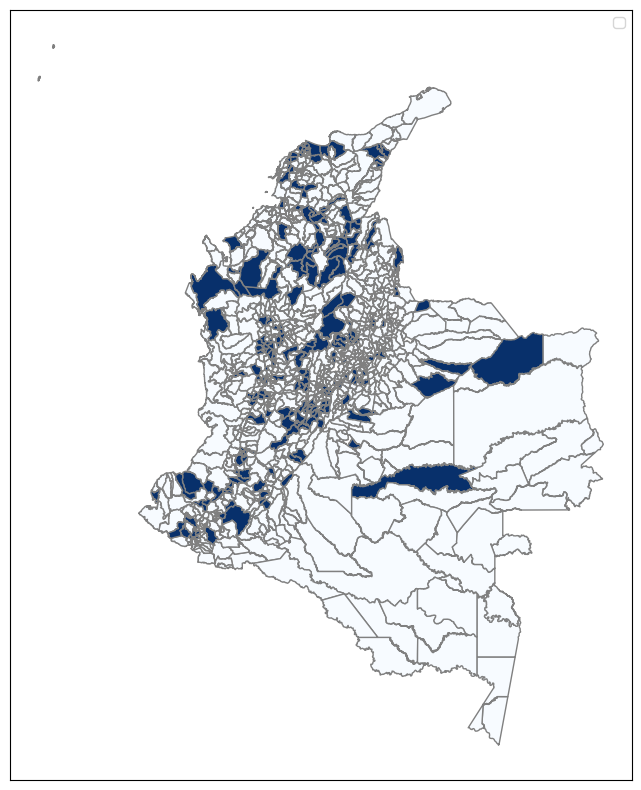

In [107]:
# Municipality
muni_sp = gpd.read_file(mainpath+'RawData/MUNICIPIOS_GEODANE/MGN_MPIO_POLITICO.shp').to_crs(epsg=9377)
muni_sp.drop(columns=['MPIO_CDPMP', 'DPTO_CNMBR', 'MPIO_CNMBR','MPIO_CRSLC', 'MPIO_NAREA', 'MPIO_CSMBL',
                      'MPIO_VGNC', 'MPIO_TIPO','Shape_Leng', 'Shape_Area',],inplace = True)

# Creating codmpio with municipality code and deparment code
muni_sp['codmpio'] = muni_sp['DPTO_CCDGO'] + muni_sp['MPIO_CCDGO']
muni_sp['codmpio'] = muni_sp['codmpio'].astype('int32')
muni_sp.drop(columns = {'DPTO_CCDGO','MPIO_CCDGO'},inplace=True)

# Creating master map
master_map = master[['codmpio', 'treat_2SD','treat_group_2SD','treat_dummy_2SD','ever_treat', 'ever_treat_no2015']].drop_duplicates(subset='codmpio')
master_map = master_map.merge(muni_sp, on='codmpio')
master_map = gpd.GeoDataFrame(data=master_map,geometry='geometry',crs=9377)

# Plotting map of municipalities on treatment group 2SD
plt.figure()

ax = master_map.plot(column = 'ever_treat_no2015', cmap = 'Blues', edgecolor = 'gray', figsize = (10, 10))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend() # Add legend

# Save the plot as a PNG file
#plt.savefig(mainpath+'Paper/Figures/muni_treated_py.png')

plt.show() # Display plot

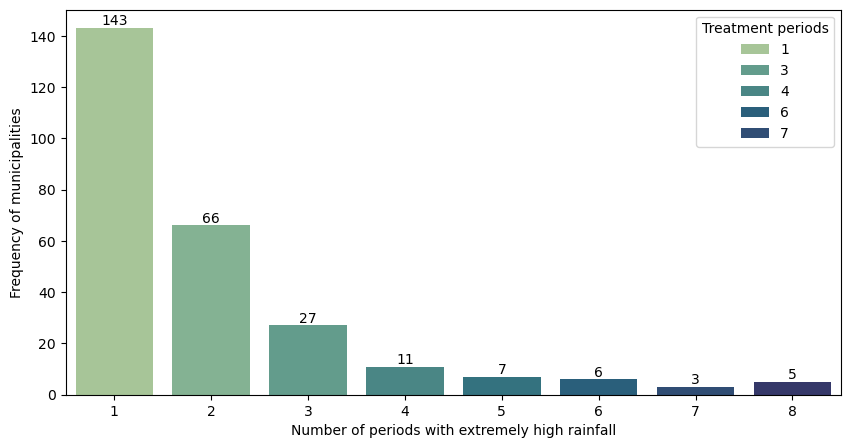

In [11]:
master_group = master.groupby(['codmpio'])['treat_2SD'].agg('sum').reset_index()
master_group.sort_values(by = 'treat_2SD', ascending = False)

plt.figure(figsize=(10, 5))
sns_count = sns.countplot( data=master_group[ master_group['treat_2SD'] != 0], 
                          x = 'treat_2SD', hue = 'treat_2SD', palette = 'crest')
sns_count.set_xlabel('Number of periods with extremely high rainfall')
sns_count.set_ylabel('Frequency of municipalities')
sns_count.legend(title ='Treatment periods', loc = 'upper right')
for i in sns_count.containers:
    sns_count.bar_label(i,)

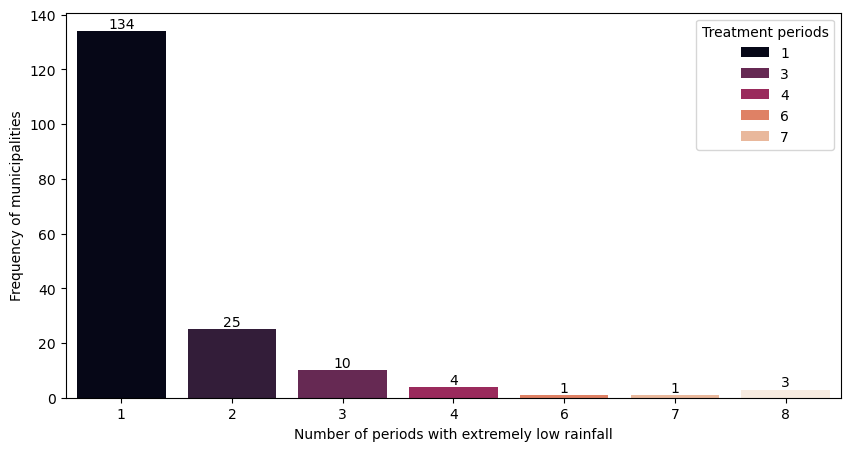

In [100]:
master_group_dry = master.groupby(['codmpio'])['treat_2SD_dry'].agg('sum').reset_index()
master_group_dry.sort_values(by = 'treat_2SD_dry', ascending=False)

plt.figure(figsize=(10, 5))
sns_count = sns.countplot( data = master_group_dry[ master_group_dry['treat_2SD_dry'] != 0], x = 'treat_2SD_dry', hue = 'treat_2SD_dry', palette = 'rocket')
sns_count.set_xlabel('Number of periods with extremely low rainfall')
sns_count.set_ylabel('Frequency of municipalities')
sns_count.legend(title ='Treatment periods', loc = 'upper right')
for i in sns_count.containers:
    sns_count.bar_label(i,)

In [101]:
master_group = master.groupby(['year'])['treat_2SD'].agg('sum').reset_index()
master_group.sort_values(by = 'treat_2SD', ascending = False)

,year,treat_2SD
7,2022,185
6,2021,119
2,2017,77
3,2018,39
5,2020,39
1,2016,36
4,2019,25
0,2015,12


In [ ]:
master_group = master[master['ever_treat_dry'] != 100].groupby(['year'])['treat_2SD'].agg('sum').reset_index()
master_group.sort_values(by = 'treat_2SD', ascending = False)

,year,treat_2SD
7,2022,160
6,2021,108
2,2017,64
5,2020,35
1,2016,33
3,2018,33
4,2019,24
0,2015,11


In [ ]:
master_group_dry = master.groupby(['year'])['treat_2SD_dry'].agg('sum').reset_index()
master_group_dry.sort_values(by = 'treat_2SD_dry', ascending=False)

,year,treat_2SD_dry
0,2015,115
7,2022,47
5,2020,30
1,2016,22
4,2019,18
6,2021,17
3,2018,10
2,2017,8


In [ ]:
master_dry_muni = master.drop_duplicates(subset='codmpio')
master_dry_muni.value_counts('treat_group_2SD_dry', dropna=False).sort_index(ascending=False) #178

treat_group_2SD_dry
2022.0     26
2021.0      7
2020.0     10
2019.0     10
2018.0      3
2017.0      1
2016.0      6
2015.0    115
0.0       932
Name: count, dtype: int64

In [16]:
master_group = master[master['ever_treat_dry'] != 100].drop_duplicates(subset = 'codmpio').groupby(['treat_group_2SD'])['codmpio'].agg('count').reset_index()
master_group.sort_values(by = 'treat_group_2SD', ascending = False)

,treat_group_2SD,codmpio
8,2022.0,69
7,2021.0,55
6,2020.0,13
5,2019.0,5
4,2018.0,10
3,2017.0,40
2,2016.0,26
1,2015.0,11
0,0.0,703


<Axes: >

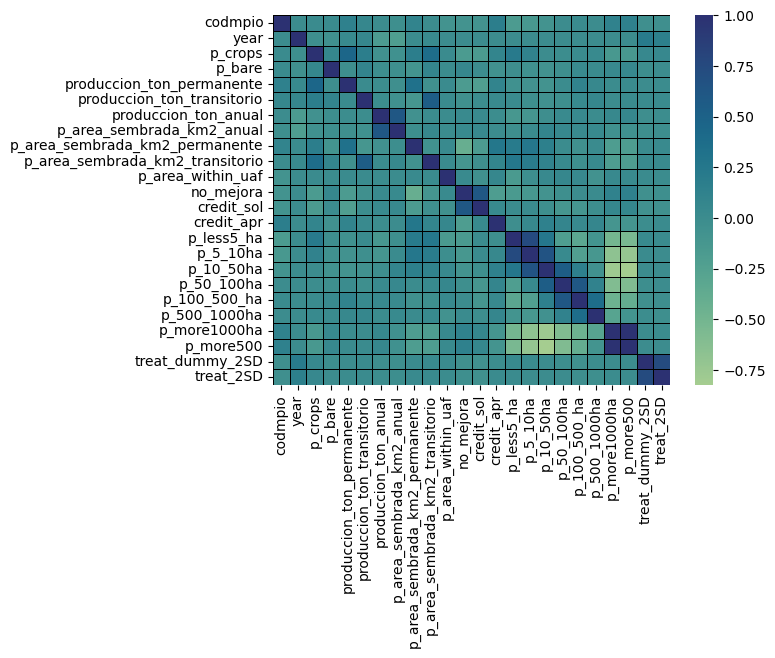

In [138]:
interest_variables = ['codmpio', 'year',
                      'p_crops','p_bare', 
                      'produccion_ton_permanente', 'produccion_ton_transitorio', 'produccion_ton_anual',
                      #'p_area_cosechada_km2_anual', 'p_area_cosechada_km2_permanente','p_area_cosechada_km2_transitorio',
                      'p_area_sembrada_km2_anual','p_area_sembrada_km2_permanente', 'p_area_sembrada_km2_transitorio',
                      #'length_within_main_roads', 'length_within_other_roads', 
                      #'p_area_within_pnn', 'p_area_within_resguardos', 
                      'p_area_within_uaf',
                      #'fer_org', 'fer_quim', 'corr_acid', 'quemas', 'rezos', 'ritos','pagamentos',
                      'no_mejora', #'disaster', 
                      'credit_sol', 'credit_apr',
                      'p_less5_ha', 'p_5_10ha', 'p_10_50ha', 'p_50_100ha', 'p_100_500_ha','p_500_1000ha','p_more1000ha',
                      'p_more500',
                      'treat_dummy_2SD', 'treat_2SD'
                      ]
sns.heatmap(master[interest_variables].corr(),cmap='crest', linewidths=0.5, linecolor='black')

In [122]:
master[['p_crops','p_bare','p_area_sembrada_km2_anual','p_area_sembrada_km2_permanente', 'p_area_sembrada_km2_transitorio']].describe()

,p_crops,p_bare,p_area_sembrada_km2_anual,p_area_sembrada_km2_permanente,p_area_sembrada_km2_transitorio
count,8880.000000,8880.000000,8880.000000,8880.000000,8880.000000
mean,3.696781,0.640611,0.300598,9.366318,4.606083
std,9.237891,2.183780,1.249538,15.251612,9.129437
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.098955,0.032676,0.000000,0.678166,0.462046
50%,0.447550,0.128054,0.000000,2.881537,1.550701
75%,2.166555,0.434888,0.098434,10.620251,4.933287
max,87.528143,48.242296,27.932948,119.488294,151.597211


# Regression section
The following code had been written in STATA and has the objetive to run the different specification of my thesis analysis using TWFE and CS methodologies.

In [ ]:
"""
*****************************
* 							*
*		Regressions			*
*							*
*****************************
/*
ssc install csdid
ssc install drdid
*/

clear all
set more off

local usuario=c(username)

if "`usuario'"=="sebas"{
	global mainpath= "C:\Users\sebas\Dropbox\Documents\Proyecto_UsosDeTierra"
}
*else if{
*	global mainpath= ""
*}

cd "${mainpath}"

use "CreatedData/dataset_landuse_v_py.dta",clear

order codmpio year, first
sort codmpio year

label var codmpio "Municipality ID"
label var total_analyzed "Area analyzed by DW ($km^2$)"
label var total_area_km2 "Municipality area($km^2$)"
* Precipitation measures
label var avg_ppm_muni "Average precipitation(mm)" 
label var avg_weighted_ppm_muni "Average precipitation weightened by subhydrographic zone(mm)"
label var avg_ppm_muni_hist "Historic average precipitation(mm)"
label var sd_ppm_muni_hist "Historic std. deviation precipitation(mm)"
label var deviation "Deviation of the historic mean"
label var deviation_weighted "Deviation weighted of the historic mean"
*Treatment dummies
label var treat_2SD "Atypic rain 2SD"
label var treat_group_2SD "First extreme weather 2SD"
label var treat_dummy_2SD "since atypic rain 2SD"
* Area variables in percentages
label var p_total_analyzed "Total area analyzed(\%)"
label var p_trees "Trees area(\%)"
label var p_crops "Crops area(\%)"
label var p_grass "Grass area(\%)"
label var p_water "Water area(\%)"
label var p_flooded_vegetation "Flooded vegetation area(\%)"
label var p_built "Built area(\%)"
label var p_bare "Bare area(\%)" 
label var p_scrub "Shrub and scrub area(\%)"
* Production covariates
label var produccion_ton_anual "Annual crops yield(tn)"
label var produccion_ton_permanente "Permanent crops yield(tn)"
label var produccion_ton_transitorio "No permanent crops yield(tn)"
* Gathered area
label var p_area_cosechada_km2_anual "Annual crops gathered(\%)"
label var p_area_cosechada_km2_permanente "Permanent crops gathered(\%)"
label var p_area_cosechada_km2_transitorio "No permanent crops gathered(\%)"
label var p_muni_area_cosechada_km2 "Gathered area (\%)"
* Planted area
label var p_area_sembrada_km2_anual "Annual crops planted(\%)"
label var p_area_sembrada_km2_permanente "Permanent crops planted(\%)"
label var p_area_sembrada_km2_transitorio "No permanent crops planted(\%)"
label var p_muni_area_sembrada_km2 "Planted area (\%)"
* Geographic covariates 
label var area_new "Municipal area CRS 9377"
label var p_area_within_pnn "PNN area(\%) "
label var p_area_within_resguardos "Resguardos area(\% )"
label var length_within_main_roads "Length main roads ($km$)"
label var length_within_other_roads "Length terciary roads ($km$)"
** Census data
* Method for land improvements
label var fer_org "Organic fertilizer use(\%)"
label var fer_quim "Chemic fertilizer use(\%)"
label var corr_acid "Acid correction(\%)"
label var quemas "Land burn(\%)"
label var no_mejora "No use of any land improvement (\%)"
label var rezos "Prayers(\%)"
label var ritos "Rituals(\%)"
label var pagamentos "Payment rituals(\%)"
* Problems with use of water
label var disaster "Water use dificulties because of a natural disaster(\%)"
* UPAs percentage by municipality
label var less5 "UPA $<$ 5 ha(\% total UPAs)"
label var bt5_10 "UPA 5ha$-$10ha(\% total UPAs)"
label var bt10_50 "UPA 10ha$-$50ha(\% total UPAs)"
label var bt50_100 "UPA 50ha$-$100ha(\% total UPAs)"
label var bt100_500 "UPA 100ha$-$500ha(\% total UPAs)"
label var bt500_1000 "UPA 500ha$-$1000ha(\% total UPAs)"
label var more1000 "UPA $+$1000(\%)"
* Land concetration
label var p_less5_ha "\% mun. area owned by UPA less than 5ha"
label var p_5_10ha "\% mun. area owned by UPA 5-10ha"
label var p_10_50ha "\% mun. area owned by UPA 10-50ha"
label var p_50_100ha "\% mun. area owned by UPA 50-100ha" 
label var p_100_500_ha "\% mun. area owned by UPA 100-500ha"
label var p_500_1000ha "\% mun. area owned by UPA 500-1000ha"
label var p_more1000ha "\% mun. area owned by UPA more than 1000ha"
label var p_more500 "Large land ownership (\%)"
* Treatment
label var ever_treat "Mun. treated"
label var ever_treat_no2015 "Mun. treated exluding always treated"

// ---------------------------------------------------- //
* Final edits
rename  p_flooded_vegetation p_f_veg
gen coddepto = (codmpio-mod(codmpio,1000))/1000

*gen log_p_max_trees = log(p_max_trees)
*tw scatter p_max_trees sd_before2000
*tw scatter log_p_max_trees sd_before2000
*tw scatter log_max_trees sd_before2000

/// ------------------------------------------------------------------------------------------------------- ///
///									Table 1: Descriptive Statistics											///
/// -------------------------------------------------------------------------------------------------------	///
/// 									Municipal characteristics											///
/// -------------------------------------------------------------------------------------------------------	///
/// Area analyzed: 						total_area_km2 														///
/// Indigena or PNN land (%):			p_area_within_pnn p_area_within_resguardos							///
/// Roads length:						length_within_main_roads length_within_other_roads					///
/// Soil improvement:					fer_org fer_quim corr_acid quemas rezos ritos pagamentos no_mejora	///
/// Water use prolem:					disaster															///
/// % # UPA within municipality 		less5 bt5_10 bt10_50 bt50_100 bt100_500 bt500_1000 more1000			///
/// area_cna_muni:						Censed municipality's area by DANE									///
/// weight UPA length on municipality	p_5_10ha p_10_50ha p_50_100ha p_100_500_ha p_500_1000ha p_more1000ha///
/// Large land ownership				p_more500															///
///	Historic precipitation 				avg_ppm_muni_hist sd_ppm_muni_hist									///
/// 																										///
/// ------------------------------------------------------------------------------------------------------- ///
/// Area analyzed by DW:				total_analyzed 											 			///
/// Percentage area analyzed: 			p_trees p_crops p_grass p_water p_f_veg p_built p_bare				///
/// Average precipitation:				avg_ppm_muni avg_weighted_ppm_mun									///
/// Deviation: 							deviation deviation_weighted										///
/// 																										///
/// ------------------------------------------------------------------------------------------------------- ///

// Municipal data
preserve
	duplicates drop codmpio, force
	sum total_area_km2 p_area_within_pnn p_area_within_resguardos length_within_main_roads length_within_other_roads fer_org fer_quim corr_acid quemas rezos ritos pagamentos no_mejora disaster less5 bt5_10 bt10_50 bt50_100 bt100_500 bt500_1000 more1000 area_cna_muni p_more500 avg_ppm_muni_hist sd_ppm_muni_hist
restore

// Panel data
sum total_analyzed p_total_analyzed p_trees p_crops p_grass p_water p_f_veg p_built p_bare avg_ppm_muni avg_weighted_ppm_muni treat_2SD treat_group_2SD treat_dummy_2SD /*p_muni_area_sembrada_km2 p_muni_area_cosechada_km2 p_area_cosechada_km2_anual p_area_cosechada_km2_permanente p_area_cosechada_km2_transitorio p_area_sembrada_km2_anual p_area_sembrada_km2_permanente p_area_sembrada_km2_transitorio*/

*** ---- Slides ---- ****

*** ---- Paper ---- ****

// Municipal information descriptive statistics
preserve
	duplicates drop codmpio, force
	eststo DS_1: estpost summarize total_area_km2 p_area_within_pnn p_area_within_resguardos /*fer_org fer_quim corr_acid quemas rezos ritos pagamentos*/ no_mejora disaster /*less5 bt5_10 bt10_50 bt50_100 bt100_500 bt500_1000 more1000 area_cna_muni*/ p_more500 length_within_main_roads length_within_other_roads avg_ppm_muni_hist sd_ppm_muni_hist // Municipal characteristics
esttab . using "Paper/Tables/desstats_1.tex", cells("mean(fmt(%9.2f)) sd(fmt(%9.2f)) min(fmt(%9.2f)) max(fmt(%9.2f)) count(fmt(%9.0f))") label replace
restore

// Panel information descriptive statistics
eststo DS_2: estpost summarize total_analyzed p_total_analyzed p_trees p_crops p_grass p_water p_f_veg p_built p_bare avg_ppm_muni avg_weighted_ppm_muni  
esttab . using "Paper/Tables/desstats_2.tex", cells("mean(fmt(%9.2f)) sd(fmt(%9.2f)) min(fmt(%9.2f)) max(fmt(%9.2f)) count(fmt(%9.0f))") label replace

eststo DS_3: estpost summarize treat_2SD treat_group_2SD treat_dummy_2SD
esttab . using "Paper/Tables/desstats_3.tex", cells("mean(fmt(%9.2f)) sd(fmt(%9.2f)) min(fmt(%9.2f)) max(fmt(%9.2f)) count(fmt(%9.0f))") label replace

eststo DS_4: estpost summarize p_area_cosechada_km2_anual p_area_cosechada_km2_permanente p_area_cosechada_km2_transitorio p_area_sembrada_km2_anual p_area_sembrada_km2_permanente p_area_sembrada_km2_transitorio
esttab . using "Paper/Tables/desstats_4.tex", cells("mean(fmt(%9.2f)) sd(fmt(%9.2f)) min(fmt(%9.2f)) max(fmt(%9.2f)) count(fmt(%9.0f))") label replace

// --------------------------------------------- //
//				Regressions - TWFE				 //
// --------------------------------------------- // 
//						TWFE					 //
// --------------------------------------------- //
//												 //
// 		Portion of trees in municipal area		 //
//												 //
// --------------------------------------------- //
preserve

local SDs "1SD 1_5SD 2SD 2_5SD" // robust errors
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	foreach SD of local SDs{
		// Regression
		qui eststo `var_reg'_`SD': reghdfe `var_reg' treat_dummy_`SD' , abs(codmpio year) cluster(codmpio)
		qui estadd scalar m_c= _b[_cons]
		qui unique codmpio if treat_dummy_`SD'==1
		qui estadd local munitreated = r(unique)
		qui unique codmpio
		qui estadd local totmunis = r(unique)
	}
	
	* ---------------- Exporting all regressions ---------------- *
	* -- Slides -- *
	estout `var_reg'_1SD `var_reg'_1_5SD `var_reg'_2SD `var_reg'_2_5SD ///
	using "Slides/Tables/TWFE/TWFE_`var_reg'_clu.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) d(_cons) ///
	prefoot(\midrule ) stats(m_c munitreated totmunis N r2 , fmt(%6.3f %3.0f %3.0f %6.0f a2 %11.2f) ///
	labels ("Mean Dep.Var. Control" "N. Obs" "\$R^2\$" )) replace
	* -- Paper --*
	estout `var_reg'_1SD `var_reg'_1_5SD `var_reg'_2SD `var_reg'_2_5SD ///
	using "Paper/Tables/TWFE/TWFE_`var_reg'_clu.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) d(_cons) ///
	prefoot(\midrule ) stats(m_c munitreated totmunis N r2 , fmt(%6.3f %3.0f %3.0f %6.0f a2 %11.2f) ///
	labels ("Mean Dep.Var. Control" "Municipalities treated" "N. Obs" "\$R^2\$" )) replace
}
* ---------------- Exporting final tables ---------------- *
* -- Slides -- *
estout p_trees_2SD  p_grass_2SD  p_crops_2SD p_water_2SD p_f_veg_2SD p_built_2SD p_bare_2SD p_scrub_2SD ///
using "Slides/Tables/TWFE_landuse_clu.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) d(_cons) ///
prefoot(\midrule ) ///
stats(m_c munitreated totmunis N r2 , fmt(%3.2f %3.0f %3.0f %6.0f a2 %11.2f) ///
labels ("Mean Dep.Var. Control" "Treated Munis" "Munis Analyzed"  "N. Obs" "\$R^2\$" )) replace
* -- Paper --*
estout p_trees_2SD  p_grass_2SD  p_crops_2SD p_water_2SD p_f_veg_2SD p_built_2SD p_bare_2SD p_scrub_2SD ///
using "Paper/Tables/TWFE/TWFE_landuse_clu.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) d(_cons) ///
prefoot(\midrule ) ///
stats(m_c munitreated totmunis N r2 , fmt(%3.2f %3.0f %3.0f %6.0f a2 %11.2f) ///
labels ("Mean Dep.Var. Control" "Treated Munis" "Munis Analyzed"  "N. Obs" "\$R^2\$" )) replace

restore

/// --------------------------------------------------- ///
///			Regressions - Callaway Sant' Anna			///
/// ---------------------------------------------------	///
set scheme s1mono

local SDs "1SD 1_5SD 2SD 2_5SD" // robust errors
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	foreach SD of local SDs{
		csdid `var_reg', ivar(codmpio) time(year) gvar(treat_group_`SD') agg(group) notyet clu(codmpio)
		estat event, estore(cs_`var_reg'_`SD')
		estat simple, estore(cs_sim_`var_reg'_`SD')
		estat group, estore(cs_gp_`var_reg'_`SD')
		estat calendar, estore(cs_cal_`var_reg'_`SD')
		estat event, window(-4 6)
		csdid_plot
		/*
		event_plot cs_`var_reg'_p00_`SD', default_look  ///
		graph_opt(xtitle("Periods since the event") ytitle("Average effect") ///
		xlabel(-6(1)6)) stub_lag(Tm4#) stub_lead(Tm#) ciplottype(rcap) together
		*/
		graph export "Slides/Figures/CS/ES_`var_reg'_`SD'.pdf", replace
		graph export "Paper/Figures/CS/ES_`var_reg'_`SD'.pdf", replace
	}	
}

// ------------------------------------------------------- //
// 				Export table: main results				   //
// ------------------------------------------------------- //
// only ATT
local SDs "1SD 1_5SD 2SD 2_5SD"
foreach SD of local SDs{
	* Export to slides
	estout cs_sim_p_trees_`SD' cs_sim_p_grass_`SD' cs_sim_p_crops_`SD' cs_sim_p_water_`SD' cs_sim_p_f_veg_`SD' cs_sim_p_built_`SD' cs_sim_p_bare_`SD' /// 
	using "Slides/Tables/CS/CS_estimation_`SD'.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
	* Export to paper
	estout cs_sim_p_trees_`SD' cs_sim_p_grass_`SD' cs_sim_p_crops_`SD' cs_sim_p_water_`SD' cs_sim_p_f_veg_`SD' cs_sim_p_built_`SD' cs_sim_p_bare_`SD' cs_sim_p_scrub_`SD' /// 
	using "Paper/Tables/CS/CS_estimation_`SD'.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
}

// With lags
local SDs "1SD 1_5SD 2SD 2_5SD"
foreach SD of local SDs{
	* Export to slides
	estout cs_p_trees_`SD' cs_p_grass_`SD' cs_p_crops_`SD' cs_p_water_`SD' cs_p_f_veg_`SD' cs_p_built_`SD' cs_p_bare_`SD' /// 
	using "Slides/Tables/CS/CS_estimationES_`SD'.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
	* Export to paper
	estout  cs_p_trees_`SD' cs_p_grass_`SD' cs_p_crops_`SD' cs_p_water_`SD' cs_p_f_veg_`SD' cs_p_built_`SD' cs_p_bare_`SD' ///
	using "Paper/Tables/CS/CS_estimationES_`SD'.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
}

// Group analysis
local SDs "1SD 1_5SD 2SD 2_5SD"
foreach SD of local SDs{
	* Export to slides
	estout cs_gp_p_trees_`SD' cs_gp_p_grass_`SD' cs_gp_p_crops_`SD' cs_gp_p_water_`SD' cs_gp_p_f_veg_`SD' cs_gp_p_built_`SD' cs_gp_p_bare_`SD' cs_gp_p_scrub_`SD' /// 
	using "Slides/Tables/CS/CS_estimation_gp_`SD'.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
	* Export to paper
	estout cs_gp_p_trees_`SD' cs_gp_p_grass_`SD' cs_gp_p_crops_`SD' cs_gp_p_water_`SD' cs_gp_p_f_veg_`SD' cs_gp_p_built_`SD' cs_gp_p_bare_`SD' cs_gp_p_scrub_`SD' ///
	using "Paper/Tables/CS/CS_estimation_gp_`SD'.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
}

// Calendar analysis
local SDs "1SD 1_5SD 2SD 2_5SD"
foreach SD of local SDs{
	* Export to slides
	estout cs_cal_p_trees_`SD' cs_cal_p_grass_`SD' cs_cal_p_crops_`SD' cs_cal_p_water_`SD' cs_cal_p_f_veg_`SD' cs_cal_p_built_`SD' cs_cal_p_bare_`SD' cs_cal_p_scrub_`SD' ///
	using "Slides/Tables/CS/CS_estimation_cal_`SD'.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
	* Export to paper
	estout cs_cal_p_trees_`SD' cs_cal_p_grass_`SD' cs_cal_p_crops_`SD' cs_cal_p_water_`SD' cs_cal_p_f_veg_`SD' cs_cal_p_built_`SD' cs_cal_p_bare_`SD' cs_cal_p_scrub_`SD' ///
	using "Paper/Tables/CS/CS_estimation_cal_`SD'.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
	label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace
}

// ---------------------------------- //
//				Graphics			  //
// ---------------------------------- //
local SDs "1SD 1_5SD 2SD 2_5SD"
foreach SD of local SDs{
	preserve
		set scheme plotplain
		duplicates drop codmpio,force
		keep if treat_group_`SD'>0
		graph bar (count), over(treat_group_`SD') blabel(bar) ytitle("# municipalities treated")
		graph export "Slides/Figures/treatment_count`SD'.pdf", replace
		graph export "Paper/Figures/treatment_count`SD'.pdf", replace
	restore
}

foreach var_reg in p_trees p_crops p_grass p_water p_f_veg  p_built p_bare p_scrub{
	coefplot ///
	(cs_`var_reg'_1SD, label(1SD) mcolor(dkgreen) ciopts(color(dkgreen%50)) rename(Pre_avg="Pre-treatment" Post_avg="Post-treatment")) /// 
	(cs_`var_reg'_1_5SD, label(1_5SD) mcolor(blue) ciopts(color(blue%50)) rename(Pre_avg="Pre-treatment" Post_avg="Post-treatment")) ///
	(cs_`var_reg'_2SD, label(2SD) mcolor(red) ciopts(color(red%50)) rename(Pre_avg="Pre-treatment" Post_avg="Post-treatment")) ///
	(cs_`var_reg'_2_5SD, label(2_5SD) mcolor(purple) ciopts(color(violet%50)) rename(Pre_avg="Pre-treatment" Post_avg="Post-treatment")), ///
	vertical yline(0) keep(Pre_avg Post_avg)
graph export "Slides/Figures/pre_pos_`var_reg'.pdf", replace
graph export "Paper/Figures/pre_pos_`var_reg'.pdf", replace
}

eststo clear

* ============================================= *
*												*
*				Group regressions				*
*												*
* ============================================= *

* ============================================================================================================ *
* Land concentration *
* ================== *
* ----   TWFE	---- *
* ================== *
* p_trees <- Nothing
* p_crops <- There is municipalities with lower land concentration than the mean (< 40.61) -1.4
* p_grass <- Nothing
* p_water <- There is municipalities with high land concentration than the mean (> 40.61) 1.2
* p_f_veg <- Nothing
* p_built <- Nothing
* p_bare  <- There is municipalities with high land concentration than the mean (> 40.61) 0.4
* p_scrub <- Nothing
* ================== *
* reghdfe p_scrub treat_dummy_2SD, abs(codmpio year) cluster(codmpio) 
* reghdfe p_scrub treat_dummy_2SD if p_more500 > 40.61, abs(codmpio year) cluster(codmpio)
* reghdfe p_scrub treat_dummy_2SD if p_more500 < 40.61, abs(codmpio year) cluster(codmpio)
* ================== *
* ----    CS 	---- *
* ================== *
* p_trees <- Nothing
* p_crops <- There is municipalities with lower land concentration than the mean (< 40.61) -1.46
* p_grass <- Nothing
* p_water <- Nothing
* p_f_veg <- Nothing
* p_built <- Nothing
* p_bare  <- There is municipalities with high land concentration than the mean (> 40.61) 0.36
* p_scrub <- Nothing
* ================== *
* csdid p_scrub, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
* csdid p_scrub if p_more500 > 40.61, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
* csdid p_scrub if p_more500 < 40.61, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
* ============================================================================================================ *
preserve
	duplicates drop codmpio, force
	tab ever_treat_no2015 if   p_more500 > 40.61
	tab ever_treat if   p_more500 > 40.61
restore

* ==========
* Above mean Land Concentration
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if p_more500 > 40.61, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_high_LC)
	estat simple, estore(cs_sim_`var_reg'_high_LC)
	estat group, estore(cs_gp_`var_reg'_high_LC)
	estat calendar, estore(cs_cal_`var_reg'_high_LC)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_high_LC.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_high_LC.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_high_LC cs_gp_p_grass_high_LC cs_gp_p_crops_high_LC cs_gp_p_water_high_LC cs_gp_p_f_veg_high_LC cs_gp_p_built_high_LC cs_gp_p_bare_high_LC cs_gp_p_scrub_high_LC /// 
using "Slides/Tables/CS/CS_estimation_gp_high_LC.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_high_LC cs_gp_p_grass_high_LC cs_gp_p_crops_high_LC cs_gp_p_water_high_LC cs_gp_p_f_veg_high_LC cs_gp_p_built_high_LC cs_gp_p_bare_high_LC cs_gp_p_scrub_high_LC /// 
using "Paper/Tables/CS/CS_estimation_gp_high_LC.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* ==========
* Below mean Land Concentration
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if p_more500 < 40.61, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_low_LC)
	estat simple, estore(cs_sim_`var_reg'_low_LC)
	estat group, estore(cs_gp_`var_reg'_low_LC)
	estat calendar, estore(cs_cal_`var_reg'_low_LC)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_low_LC.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_low_LC.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_low_LC cs_gp_p_grass_low_LC cs_gp_p_crops_low_LC cs_gp_p_water_low_LC cs_gp_p_f_veg_low_LC cs_gp_p_built_low_LC cs_gp_p_bare_low_LC cs_gp_p_scrub_low_LC /// 
using "Slides/Tables/CS/CS_estimation_gp_low_LC.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_low_LC cs_gp_p_grass_low_LC cs_gp_p_crops_low_LC cs_gp_p_water_low_LC cs_gp_p_f_veg_low_LC cs_gp_p_built_low_LC cs_gp_p_bare_low_LC cs_gp_p_scrub_low_LC ///
using "Paper/Tables/CS/CS_estimation_gp_low_LC.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* ============================================================================================================ *
* 		 PNN 		 *
* ================== *
* ----   TWFE	---- *
* ================== *
* p_trees <- Nothing
* p_crops <- Nothing
* p_grass <- There is reduction on %PNN > 12 (-2.31) and increasing in %PNN < 12 (1.0)
* p_water <- There is increasing in both groups
* p_f_veg <- Nothing
* p_built <- There is increasing on %PNN < 12 (0.28)
* p_bare  <- There is increasing on %PNN < 12 (0.24) 
* p_scrub <- Nothing
* ================== *
/*
reghdfe p_crops treat_dummy_2SD if p_area_within_pnn > 12, abs(codmpio year) cluster(codmpio)
reghdfe p_crops treat_dummy_2SD if p_area_within_pnn < 12, abs(codmpio year) cluster(codmpio)
*/
* ================== *
* ----    CS 	---- *
* ================== *
* p_trees <- Nothing
* p_crops <- There is reduction on %PNN < 12 (-0.98)
* p_grass <- Nothing
* p_water <- Nothing
* p_f_veg <- Nothing
* p_built <- There is increasing on %PNN < 12 (0.33)
* p_bare  <- There is increasing on %PNN < 12 (0.30) 
* p_scrub <- Nothing
* ================== *
/*
csdid p_scrub if p_area_within_pnn > 12, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
csdid p_scrub if p_area_within_pnn < 12, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
*/
* ============================================================================================================ *

* ==========
* Above mean PNN
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if p_area_within_pnn > 12, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_high_PNN)
	estat simple, estore(cs_sim_`var_reg'_high_PNN)
	estat group, estore(cs_gp_`var_reg'_high_PNN)
	estat calendar, estore(cs_cal_`var_reg'_high_PNN)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_high_PNN.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_high_PNN.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_high_PNN cs_gp_p_grass_high_PNN cs_gp_p_crops_high_PNN cs_gp_p_water_high_PNN cs_gp_p_f_veg_high_PNN cs_gp_p_built_high_PNN cs_gp_p_bare_high_PNN cs_gp_p_scrub_high_PNN /// 
using "Slides/Tables/CS/CS_estimation_gp_high_PNN.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_high_PNN cs_gp_p_grass_high_PNN cs_gp_p_crops_high_PNN cs_gp_p_water_high_PNN cs_gp_p_f_veg_high_PNN cs_gp_p_built_high_PNN cs_gp_p_bare_high_PNN cs_gp_p_scrub_high_PNN /// 
using "Paper/Tables/CS/CS_estimation_gp_high_PNN.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* ==========
* Below mean PNN
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if p_area_within_pnn < 12, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_low_PNN)
	estat simple, estore(cs_sim_`var_reg'_low_PNN)
	estat group, estore(cs_gp_`var_reg'_low_PNN)
	estat calendar, estore(cs_cal_`var_reg'_low_PNN)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_low_PNN.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_low_PNN.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_low_PNN cs_gp_p_grass_low_PNN cs_gp_p_crops_low_PNN cs_gp_p_water_low_PNN cs_gp_p_f_veg_low_PNN cs_gp_p_built_low_PNN cs_gp_p_bare_low_PNN cs_gp_p_scrub_low_PNN /// 
using "Slides/Tables/CS/CS_estimation_gp_low_PNN.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_low_PNN cs_gp_p_grass_low_PNN cs_gp_p_crops_low_PNN cs_gp_p_water_low_PNN cs_gp_p_f_veg_low_PNN cs_gp_p_built_low_PNN cs_gp_p_bare_low_PNN cs_gp_p_scrub_low_PNN ///
using "Paper/Tables/CS/CS_estimation_gp_low_PNN.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* ============================================================================================================ *
* 	   Resguardos	 *
* ================== *
* ----   TWFE	---- *
* ================== *
* p_trees <- Nothing
* p_crops <- Nothing
* p_grass <- There is a reduction on %resguardos < 5 (-0.96)
* p_water <- There is an increasing on %resguardos > 5 (2.99)
* p_f_veg <- Nothing
* p_built <- Nothing
* p_bare  <- There is an increasing on %resguardos > 5 (1.11) 
* p_scrub <- Nothing
* ================== *
/*
reghdfe p_scrub treat_dummy_2SD if p_area_within_resguardos > 5, abs(codmpio year) cluster(codmpio)
reghdfe p_scrub treat_dummy_2SD if p_area_within_resguardos < 5, abs(codmpio year) cluster(codmpio)
*/
* ================== *
* ----    CS 	---- *
* ================== *
* p_trees <- Nothing
* p_crops <- Nothing
* p_grass <- Nothing
* p_water <- There is an increasing on %resguardos > 5 (0.87)
* p_f_veg <- Nothing
* p_built <- Nothing
* p_bare  <- There is an increasing on %resguardos < 5 (0.16)
* p_scrub <- Nothing
* ================== *
/*
csdid p_scrub if p_area_within_resguardos > 5, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
csdid p_scrub if p_area_within_resguardos < 5, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
*/
* ============================================================================================================ *

* ==========
* Above mean Resguardos
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if p_area_within_resguardos > 5, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_high_ind)
	estat simple, estore(cs_sim_`var_reg'_high_ind)
	estat group, estore(cs_gp_`var_reg'_high_ind)
	estat calendar, estore(cs_cal_`var_reg'_high_ind)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_high_ind.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_high_ind.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_high_ind cs_gp_p_grass_high_ind cs_gp_p_crops_high_ind cs_gp_p_water_high_ind cs_gp_p_f_veg_high_ind cs_gp_p_built_high_ind cs_gp_p_bare_high_ind cs_gp_p_scrub_high_ind ///  
using "Slides/Tables/CS/CS_estimation_gp_high_ind.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_high_ind cs_gp_p_grass_high_ind cs_gp_p_crops_high_ind cs_gp_p_water_high_ind cs_gp_p_f_veg_high_ind cs_gp_p_built_high_ind cs_gp_p_bare_high_ind cs_gp_p_scrub_high_ind /// 
using "Paper/Tables/CS/CS_estimation_gp_high_ind.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* ==========
* Below mean Resguardos
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if p_area_within_resguardos < 5, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_low_ind)
	estat simple, estore(cs_sim_`var_reg'_low_ind)
	estat group, estore(cs_gp_`var_reg'_low_ind)
	estat calendar, estore(cs_cal_`var_reg'_low_ind)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_low_ind.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_low_ind.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_low_ind cs_gp_p_grass_low_ind cs_gp_p_crops_low_ind cs_gp_p_water_low_ind cs_gp_p_f_veg_low_ind cs_gp_p_built_low_ind cs_gp_p_bare_low_ind cs_gp_p_scrub_low_ind ///
using "Slides/Tables/CS/CS_estimation_gp_low_ind.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_low_ind cs_gp_p_grass_low_ind cs_gp_p_crops_low_ind cs_gp_p_water_low_ind cs_gp_p_f_veg_low_ind cs_gp_p_built_low_ind cs_gp_p_bare_low_ind cs_gp_p_scrub_low_ind ///
using "Paper/Tables/CS/CS_estimation_gp_low_ind.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* ============================================================================================================ *
* 	 No mejora suelos	 *
* ====================== *
/*
csdid p_scrub if no_mejora > 42.9, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
csdid p_scrub if no_mejora < 42.9, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
*/
* ============================================================================================================ *

* ==========
* Above mean No mejora suelo
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if no_mejora > 42.9, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_high_no_mej)
	estat simple, estore(cs_sim_`var_reg'_high_no_mej)
	estat group, estore(cs_gp_`var_reg'_high_no_mej)
	estat calendar, estore(cs_cal_`var_reg'_high_no_mej)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_high_no_mejora.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_high_no_mejora.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_high_no_mej cs_gp_p_grass_high_no_mej cs_gp_p_crops_high_no_mej cs_gp_p_water_high_no_mej cs_gp_p_f_veg_high_no_mej cs_gp_p_built_high_no_mej cs_gp_p_bare_high_no_mej cs_gp_p_scrub_high_no_mej ///  
using "Slides/Tables/CS/CS_estimation_gp_high_no_mejora.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_high_no_mej cs_gp_p_grass_high_no_mej cs_gp_p_crops_high_no_mej cs_gp_p_water_high_no_mej cs_gp_p_f_veg_high_no_mej cs_gp_p_built_high_no_mej cs_gp_p_bare_high_no_mej cs_gp_p_scrub_high_no_mej ///
using "Paper/Tables/CS/CS_estimation_gp_high_no_mejora.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* ==========
* Below mean Resguardos
* ==========
foreach var_reg in p_trees p_crops p_grass p_water p_f_veg p_built p_bare p_scrub{
	csdid `var_reg' if no_mejora < 42.9, ivar(codmpio) time(year) gvar(treat_group_2SD) agg(group) notyet clu(codmpio)
	estat event, estore(cs_`var_reg'_low_no_mej)
	estat simple, estore(cs_sim_`var_reg'_low_no_mej)
	estat group, estore(cs_gp_`var_reg'_low_no_mej)
	estat calendar, estore(cs_cal_`var_reg'_low_no_mej)
	estat event, window(-4 6)
	csdid_plot
	* Export graph
	graph export "Slides/Figures/CS/ES_`var_reg'_low_no_mejora.pdf", replace
	graph export "Paper/Figures/CS/ES_`var_reg'_low_no_mejora.pdf", replace	
}

* Export to slides
estout cs_gp_p_trees_low_no_mej cs_gp_p_grass_low_no_mej cs_gp_p_crops_low_no_mej cs_gp_p_water_low_no_mej cs_gp_p_f_veg_low_no_mej cs_gp_p_built_low_no_mej cs_gp_p_bare_low_no_mej cs_gp_p_scrub_low_no_mej ///
using "Slides/Tables/CS/CS_estimation_gp_low_no_mejora.tex",style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace

* Export to paper
estout cs_gp_p_trees_low_no_mej cs_gp_p_grass_low_no_mej cs_gp_p_crops_low_no_mej cs_gp_p_water_low_no_mej cs_gp_p_f_veg_low_no_mej cs_gp_p_built_low_no_mej cs_gp_p_bare_low_no_mej cs_gp_p_scrub_low_no_mej ///
using "Paper/Tables/CS/CS_estimation_gp_low_no_mejora.tex", style(tex) starl(* 0.10 ** 0.05 *** 0.01) /// 
label cells(b(star fmt(a2)) se(par fmt(a2))) mlabels(none) collabels(none) replace"


"""